In [22]:
import sys
from pathlib import Path
ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))
    
from config import DB_URI
from sqlalchemy import create_engine, text
import pandas as pd
from tqdm import tqdm


engine = create_engine(DB_URI)

with engine.connect() as conn:
    total = conn.execute(text("SELECT COUNT(*) FROM incidents")).scalar()

batch_size = 5000
offset = 0
rows = []

with engine.connect() as conn, tqdm(total=total, desc="Загрузка данных", unit="строк") as pbar:
    while True:
        query = f"""
            SELECT 
                mf.*, 
                i.business_status,
                mpf.is_weak_motion, mpf.is_slow_progress, mpf.is_circular_motion, mpf.is_no_motion, mpf.timestamp AS mpf_timestamp,
                rf.looks_like_rent, rf.movement_after_rent, rf.moved_without_rent, rf.moved_immediately_after_rent,
                rf.returned_to_access_5min, rf.had_rent_last_2h, rf.end_is_start, rf.timestamp AS rf_timestamp,
                tf.is_night_alarm, tf.alarm_delay_seconds, tf.alarm_hour, tf.timestamp AS tf_timestamp,
                zf.was_in_tech_zone_before_alarm, zf.was_in_restricted_zone_before_alarm, zf.timestamp AS zf_timestamp,
                gqf.valid_coord_ratio, gqf.average_satellites, gqf.average_rssi, gqf.unstable_gps_jumps, gqf.timestamp AS gqf_timestamp, gqf.detected_jumps,
                oc.comment, oc.created_at AS comment_created_at
            FROM movement_features mf
            LEFT JOIN incidents i ON mf.incident_id = i.id
            LEFT JOIN motion_pattern_features mpf ON mf.incident_id = mpf.incident_id
            LEFT JOIN rental_features rf ON mf.incident_id = rf.incident_id
            LEFT JOIN time_features tf ON mf.incident_id = tf.incident_id
            LEFT JOIN zone_features zf ON mf.incident_id = zf.incident_id
            LEFT JOIN gps_quality_features gqf ON mf.incident_id = gqf.incident_id
            LEFT JOIN operator_comments oc ON mf.incident_id = oc.incident_id
            ORDER BY mf.id
            OFFSET {offset} LIMIT {batch_size}
            """
        batch = pd.read_sql_query(text(query), conn)

        if batch.empty:
            break

        rows.append(batch)
        offset += batch_size
        pbar.update(len(batch))

df = pd.concat(rows, ignore_index=True)


In [ ]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_timestamp') or col.endswith('_created_at')])
df

In [ ]:
nan_summary = df.isnull().sum().to_frame(name='missing_count')
nan_summary['missing_percent'] = (nan_summary['missing_count'] / len(df)) * 100

nan_summary = nan_summary.sort_values(by='missing_count', ascending=False)

print(nan_summary)

In [41]:
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

In [ ]:
df = df.drop(columns=['id'])
df.columns

In [ ]:
df['alarm_delay_seconds'] = df['alarm_delay_seconds'].fillna(-1)

binary_nan_cols = [
    'is_circular_motion',
    'was_in_tech_zone_before_alarm',
    'was_in_restricted_zone_before_alarm',
    'moved_immediately_after_rent',
    'had_rent_last_2h',
    'returned_to_access_5min',
    'is_back_and_forth'
]

for col in binary_nan_cols:
    df[col] = df[col].map({'True': True, 'False': False})
    df[col] = df[col].fillna(False).astype(int)


In [32]:
print(df['business_status'].isnull().sum())
print(df['business_status'].unique())

164961
[nan 'Investigation']


In [ ]:
drop_cols = [
    'was_in_restricted_zone_before_alarm',
    'was_in_tech_zone_before_alarm',
    'had_rent_last_2h',
    'moved_immediately_after_rent',
    'returned_to_access_5min',
    'is_circular_motion',
    'is_back_and_forth'
]

df.drop(columns=drop_cols, inplace=True)

In [49]:
df.drop(columns=['incident_id'], inplace=True)
df.columns

Index(['max_speed_kmh', 'mean_speed_kmh', 'median_speed_kmh',
       'is_too_fast_speed', 'is_too_fast_trip', 'is_only_linear_segments',
       'is_zigzag', 'is_highly_linear', 'has_long_stop', 'total_distance',
       'track_point_count', 'business_status', 'is_weak_motion',
       'is_slow_progress', 'is_no_motion', 'looks_like_rent',
       'moved_without_rent', 'end_is_start', 'is_night_alarm',
       'alarm_delay_seconds', 'alarm_hour', 'valid_coord_ratio',
       'average_satellites', 'average_rssi', 'unstable_gps_jumps',
       'detected_jumps', 'comment'],
      dtype='object')

In [52]:
import pandas as pd

numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
numeric_cols = [col for col in numeric_cols if col not in ['id', 'incident_id']]

detailed_stats = pd.DataFrame()

for col in numeric_cols:
    stats = {
        'mean': df[col].mean(),
        'std': df[col].std(),
        'min': df[col].min(),
        '1%': df[col].quantile(0.01),
        '5%': df[col].quantile(0.05),
        '25%': df[col].quantile(0.25),
        '50%': df[col].median(),
        '75%': df[col].quantile(0.75),
        '95%': df[col].quantile(0.95),
        '99%': df[col].quantile(0.99),
        'max': df[col].max(),
        'skew': df[col].skew()
    }
    detailed_stats[col] = pd.Series(stats)

detailed_stats = detailed_stats.T

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
print(detailed_stats)


                                mean           std   min    1%     5%  \
max_speed_kmh             214,551.63 14,418,327.11  0.00  0.00   0.23   
mean_speed_kmh             18,947.60  2,231,698.28  0.00  0.00   0.05   
median_speed_kmh              241.13     20,765.80  0.00  0.00   0.00   
is_too_fast_speed               0.73          0.44  0.00  0.00   0.00   
is_too_fast_trip                0.61          0.49  0.00  0.00   0.00   
is_only_linear_segments         0.38          0.49  0.00  0.00   0.00   
is_zigzag                       0.67          0.47  0.00  0.00   0.00   
is_highly_linear                0.08          0.27  0.00  0.00   0.00   
has_long_stop                   0.95          0.21  0.00  0.00   1.00   
total_distance          2,035,680.18  8,652,500.96  0.00  0.00   2.63   
track_point_count              38.37         38.62  2.00  3.00   4.00   
is_weak_motion                  0.12          0.32  0.00  0.00   0.00   
is_slow_progress                0.14          0.35 

In [53]:
clip_config = {
    'max_speed_kmh': (0.001, 0.999),
    'mean_speed_kmh': (0.001, 0.999),
    'median_speed_kmh': (0.005, 0.995),
    'total_distance': (0.005, 0.995),
    'track_point_count': (0.01, 0.99),
    'alarm_delay_seconds': (0.01, 0.99),
    'average_satellites': (0.01, 0.99),
    'average_rssi': (0.01, 0.95),
    'unstable_gps_jumps': (0.01, 0.99),
    'detected_jumps': (0.005, 0.995)
}

for col, (q_low, q_high) in clip_config.items():
    lower = df[col].quantile(q_low)
    upper = df[col].quantile(q_high)

    df[f'{col}_is_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    df[col] = df[col].clip(lower=lower, upper=upper)

    print(f"✅ {col}: clipped between {q_low*100:.1f}–{q_high*100:.1f}% "
          f"→ [{lower:.2f}, {upper:.2f}]")

✅ max_speed_kmh: clipped between 0.1–99.9% → [0.00, 10456857.47]
✅ mean_speed_kmh: clipped between 0.1–99.9% → [0.00, 467203.00]
✅ median_speed_kmh: clipped between 0.5–99.5% → [0.00, 206.94]
✅ total_distance: clipped between 0.5–99.5% → [0.00, 52486586.74]
✅ track_point_count: clipped between 1.0–99.0% → [3.00, 225.00]
✅ alarm_delay_seconds: clipped between 1.0–99.0% → [-1.00, 884373.17]
✅ average_satellites: clipped between 1.0–99.0% → [0.00, 30.75]
✅ average_rssi: clipped between 1.0–95.0% → [0.00, 97.00]
✅ unstable_gps_jumps: clipped between 1.0–99.0% → [0.00, 62.00]
✅ detected_jumps: clipped between 0.5–99.5% → [0.00, 63.00]


In [55]:
df['business_status'] = df['business_status'].fillna('0')
df['business_status'] = df['business_status'].replace('Investigation', '1')
df['business_status'] = df['business_status'].astype(int)

In [60]:
import ast
import pandas as pd

df['comment_flag'] = df['comment'].notnull().astype(int)

parsed_comments = df.loc[df['comment_flag'] == 1, 'comment'].apply(ast.literal_eval)

comment_df = pd.json_normalize(parsed_comments).add_prefix("comment_").astype(int)

df = df.join(comment_df)

comment_counts = df[comment_df.columns].apply(lambda col: col.value_counts()).T.fillna(0).astype(int)
comment_counts.columns = ['count_0', 'count_1']

print(comment_counts)

                            count_0  count_1
comment_needs_repair          42824      730
comment_low_battery           42990      564
comment_outside_zone          43357      197
comment_rent_blocked          43024      530
comment_alarm_movement        42148     1406
comment_returned_to_access    23130    20424
comment_awaiting_service      43482       72


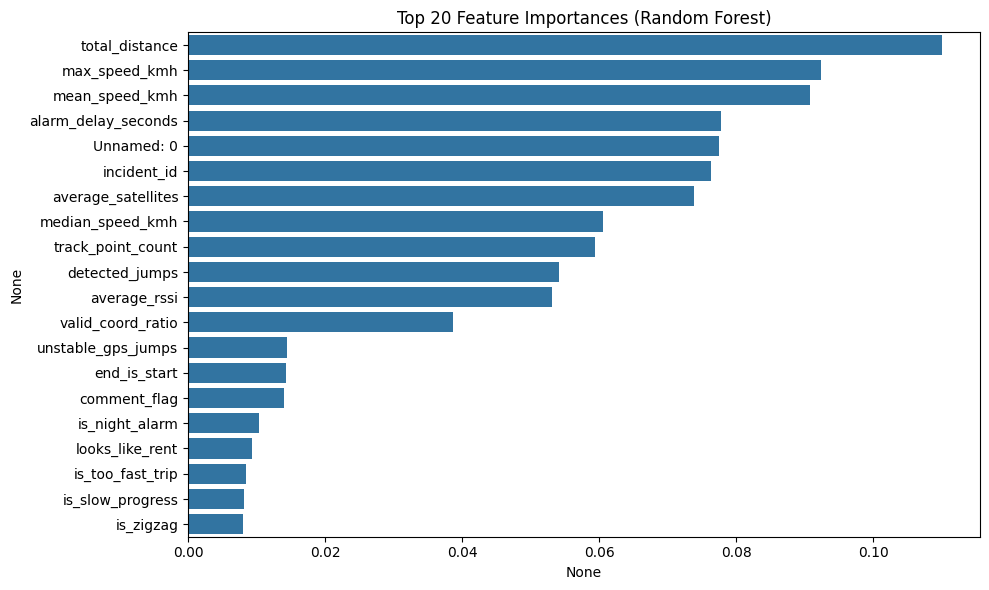

📊 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     32993
           1       0.89      0.42      0.57      1679

    accuracy                           0.97     34672
   macro avg       0.93      0.71      0.78     34672
weighted avg       0.97      0.97      0.96     34672



In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Подготовим данные
X = df[num_cols.columns]
y = df['business_status']

# Тренировочный и тестовый сплиты
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Обучим Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Визуализация топ-20 фичей
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(20), y=importances.head(20).index)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# Оценка модели
y_pred_rf = rf.predict(X_test)
print("📊 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Предсказания модели (предположим, y_test и y_pred_rf уже есть)
cm = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])

# Визуализация
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [70]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, recall_score
import numpy as np

# Делим данные заранее
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [1, 3, 5, 8]),
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores, recalls = [], []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        f1_scores.append(f1_score(y_val, y_pred, pos_label=1))
        recalls.append(recall_score(y_val, y_pred, pos_label=1))

    return 0.6 * np.mean(f1_scores) + 0.4 * np.mean(recalls)


In [72]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=1800)  # 50 попыток, 30 минут

print("Лучшие параметры:")
print(study.best_trial.params)

[I 2025-04-14 09:53:26,227] A new study created in memory with name: no-name-fc1916e0-d715-4423-ad1e-9dde7c0bb0a1
/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:53:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:53:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:53:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/kdankova/jet_alerts/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:53:29] WARNING: /workspace/src/learner.cc:738: 
P

📌 Лучшие параметры:
{'n_estimators': 381, 'max_depth': 11, 'learning_rate': 0.020811314491452987, 'subsample': 0.713334119468803, 'colsample_bytree': 0.6507939543410076, 'gamma': 4.56421884069221, 'reg_alpha': 0.33586689099024253, 'reg_lambda': 0.3201032357284993, 'scale_pos_weight': 8}



📈 Threshold: 0.5
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     32993
           1       0.46      0.77      0.57      1679

    accuracy                           0.94     34672
   macro avg       0.72      0.86      0.77     34672
weighted avg       0.96      0.94      0.95     34672

ROC AUC: 0.9622238799657307


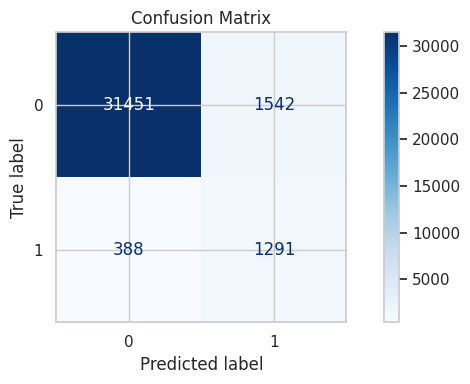

<Figure size 1000x800 with 0 Axes>

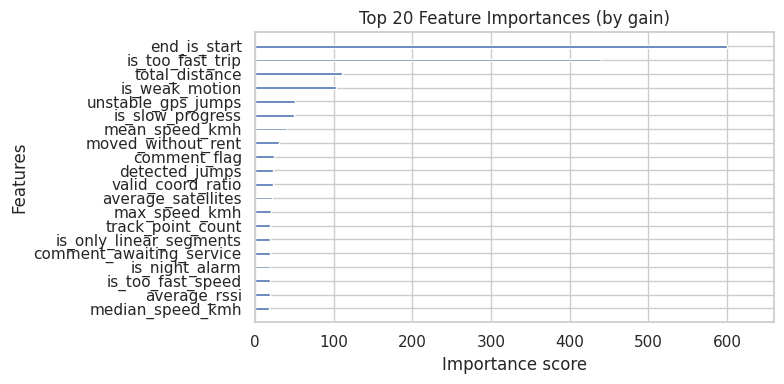

In [74]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Обучаем лучшую модель на всём тренировочном X_train
best_params = study.best_trial.params
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Оцениваем на holdout валидации
y_probs = best_model.predict_proba(X_valid)[:, 1]
best_thresh = 0.5  # или find_best_threshold(y_valid, y_probs)

y_pred = (y_probs > best_thresh).astype(int)

# === Метрики
print(f"\n📈 Threshold: {best_thresh}")
print(classification_report(y_valid, y_pred))
print("ROC AUC:", roc_auc_score(y_valid, y_probs))

# === Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Построим importance plot после обучения модели
plt.figure(figsize=(10, 8))
plot_importance(best_model, max_num_features=20, importance_type='gain', show_values=False)
plt.title("Top 20 Feature Importances (by gain)")
plt.tight_layout()
plt.show()


In [ ]:
import pickle
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost import XGBClassifier

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Восстановленные лучшие параметры
best_params = {
    'n_estimators': 381,
    'max_depth': 11,
    'learning_rate': 0.020811314491452987,
    'subsample': 0.713334119468803,
    'colsample_bytree': 0.6507939543410076,
    'gamma': 4.56421884069221,
    'reg_alpha': 0.33586689099024253,
    'reg_lambda': 0.3201032357284993,
    'scale_pos_weight': 8,
    'eval_metric': 'logloss'
}

# Обучаем модель
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Сохраняем модель через pickle
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Модель сохранена в model_xgb_14_04.pkl")

# Сохраняем список признаков
feature_list = X_train.columns.tolist()
with open("xgb_features.txt", "w") as f:
    for feat in feature_list:
        f.write(feat + "\n")

print("Список признаков сохранён в xgb_features.txt")


In [18]:
import pandas as pd
df = pd.read_csv('/home/kdankova/jet_alerts/data/preprocessed_dataset_v2.csv')

In [5]:
num_cols = df.select_dtypes(include=["int64", "float64"]).drop(columns=["business_status"])


In [12]:
X = df[num_cols.columns]
y = df['business_status']

In [13]:
X = X.drop(columns='Unnamed: 0')

In [ ]:
df['incident_id'] = df_raw['incident_id'].reset_index(drop=True)
df

In [ ]:
df.columns

In [23]:
import pandas as pd
import pickle

# Загрузка модели
with open("/home/kdankova/jet_alerts/models/model_xgb_14_04.pkl", "rb") as f:
    model = pickle.load(f)

# Загрузка списка признаков, на которых модель обучалась
with open("/home/kdankova/jet_alerts/data/xgb_features.txt") as f:
    feature_list = [line.strip() for line in f.readlines()]

# Отбираем фичи и делаем предикт
X = df[feature_list]
y_probs = model.predict_proba(X)[:, 1]  # если нужен predict → model.predict(X)

# Склеиваем с айди
results = df[['incident_id']].copy()
results['prediction'] = y_probs

results

,incident_id,prediction
0,148587,0.008220
1,148592,0.001199
2,148596,0.002668
3,148586,0.012545
4,148589,0.001660
...,...,...
173353,297055,0.013806
173354,297064,0.039649
173355,297066,0.202984
173356,297068,0.022921


In [24]:
results.sort_values('prediction', ascending=False).head(10)

,incident_id,prediction
115314,246955,0.986819
115320,246955,0.986819
115312,246955,0.986819
115313,246955,0.986819
115319,246955,0.986819
115318,246955,0.986819
115325,246955,0.986819
115321,246955,0.986819
115315,246955,0.986819
115327,246955,0.986819


In [28]:
targets = [0.1 * i for i in range(1, 11)]
for t in targets:
    closest = results.iloc[(results['prediction'] - t).abs().argsort()[:2]]
    print(f"\n Ближайшие к {int(t*100)}%:")
    print(closest)


 Ближайшие к 10%:
        incident_id  prediction
60504        201015    0.099995
152642       279476    0.100010

 Ближайшие к 20%:
        incident_id  prediction
67623        206764    0.200008
142763       270862    0.200013

 Ближайшие к 30%:
        incident_id  prediction
144779       272553    0.300027
144780       272553    0.300027

 Ближайшие к 40%:
       incident_id  prediction
32150       176109    0.399999
32148       176109    0.399999

 Ближайшие к 50%:
        incident_id  prediction
147813       275201    0.500044
102192       235552    0.499948

 Ближайшие к 60%:
        incident_id  prediction
165581       290460    0.599993
42097        185083    0.600025

 Ближайшие к 70%:
        incident_id  prediction
126410       256665    0.700041
86523        222767    0.700050

 Ближайшие к 80%:
       incident_id  prediction
66026       205469    0.800008
62180       202478    0.800008

 Ближайшие к 90%:
       incident_id  prediction
49860       191649    0.900045
49861

In [31]:
print(df.dtypes)

Unnamed: 0                          int64
max_speed_kmh                     float64
mean_speed_kmh                    float64
median_speed_kmh                  float64
is_too_fast_speed                   int64
is_too_fast_trip                    int64
is_only_linear_segments             int64
is_zigzag                           int64
is_highly_linear                    int64
has_long_stop                       int64
total_distance                    float64
track_point_count                   int64
business_status                     int64
is_weak_motion                      int64
is_slow_progress                    int64
is_no_motion                        int64
looks_like_rent                     int64
moved_without_rent                  int64
end_is_start                        int64
is_night_alarm                      int64
alarm_delay_seconds               float64
alarm_hour                         object
valid_coord_ratio                 float64
average_satellites                